# Plotting glider tracks

_Written by Lori Garzio, June 19, 2023_

[Rutgers Center for Ocean Observing Leadership](https://rucool.marine.rutgers.edu/) (RUCOOL)

This notebook shows you how to plot glider tracks from multiple gliders on a map along with bathymetry. In this example we will be using data manually downloaded from the [IOOS Glider DAC ERDDAP server](https://gliders.ioos.us/erddap/index.html). See the download_data_dac notebook for detailed instructions.

In [1]:
# import required packages
import os
import datetime as dt
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from mpl_toolkits.axes_grid1 import make_axes_locatable
import cmocean as cmo

Specify the file paths for the datasets you would like to plot and the bathymetry data file. Load the datasets using xarray.

In [2]:
f_ru30_2019 = '/Users/garzio/Documents/rucool/gliderdata/ru30-20190717T1812-delayed.nc'
f_ru30_2021 = '/Users/garzio/Documents/rucool/gliderdata/ru30-20210716T1804-delayed.nc'
f_sbu01_2021 = '/Users/garzio/Documents/rucool/gliderdata/SBU01-20210723T1544-delayed.nc'
bathymetry = '/Users/garzio/Documents/rucool/bathymetry/GEBCO_2014_2D_-100.0_0.0_-10.0_50.0.nc'

ds_ru30_2019 = xr.open_dataset(f_ru30_2019)
ds_ru30_2021 = xr.open_dataset(f_ru30_2021)
ds_sbu01_2021 = xr.open_dataset(f_sbu01_2021)
bathy_ds = xr.open_dataset(bathymetry)

Specify where you want the plot to be saved on your local machine.

In [3]:
save_dir = '/Users/garzio/Documents/rucool/gliderplots'

Look at the first dataset for variables, time range, etc.

In [4]:
ds_ru30_2019

<xarray.Dataset>
Dimensions:                     (row: 932097)
Dimensions without coordinates: row
Data variables: (12/22)
    time                        (row) datetime64[ns] ...
    latitude                    (row) float64 ...
    longitude                   (row) float64 ...
    depth                       (row) float32 ...
    aragonite_saturation_state  (row) float64 ...
    chlorophyll_a               (row) float64 ...
    ...                          ...
    pressure                    (row) float32 ...
    salinity                    (row) float32 ...
    temperature                 (row) float32 ...
    total_alkalinity            (row) float64 ...
    mld                         (row) float64 ...
    mld_dbar                    (row) float64 ...
Attributes: (12/67)
    acknowledgment:                  This deployment supported by National Sc...
    cdm_data_type:                   TrajectoryProfile
    cdm_profile_variables:           time_uv,lat_uv,lon_uv,u,v,profile_id,tim...
    cdm_trajectory_variables:        trajectory,wmo_id
    comment:                         Deployed by Chip Haldeman, Nicole Waite,...
    contributor_name:                Grace Saba,Travis Miles,Liza Wright-Fair...
    ...                              ...
    subsetVariables:                 wmo_id,trajectory,profile_id,time,latitu...
    summary:                         This project integrated a deep rated ver...
    time_coverage_end:               2019-08-12T15:14:53Z
    time_coverage_start:             2019-07-17T16:28:21Z
    title:                           ru30-20190717T1812-delayed
    Westernmost_Easting:             -73.84989712666668

Swap the dimensions to 'time' for all 3 datasets. This makes it easier to subset the dataset by time if you want to do that for any reason. 

In [5]:
ds_ru30_2019 = ds_ru30_2019.swap_dims({'row': 'time'})
ds_ru30_2021 = ds_ru30_2021.swap_dims({'row': 'time'})
ds_sbu01_2021 = ds_sbu01_2021.swap_dims({'row': 'time'})

Define the bounding box for the map. You can changed this depending on the deployments you want to plot.

In [6]:
extent = [-76, -71.3, 38, 41]

Subset the bathymetry dataset using your plotting limits so you aren't trying to plot a large amount of data.

In [7]:
bathy_ds = bathy_ds.sel(lon=slice(extent[0], extent[1]),
                        lat=slice(extent[2], extent[3]))

bathy_ds

<xarray.Dataset>
Dimensions:    (lat: 360, lon: 564)
Coordinates:
  * lat        (lat) float64 38.0 38.01 38.02 38.03 ... 40.97 40.98 40.99 41.0
  * lon        (lon) float64 -76.0 -75.99 -75.98 -75.97 ... -71.32 -71.31 -71.3
Data variables:
    elevation  (lat, lon) float64 ...
Attributes:
    Conventions:  CF-1.0
    title:        The GEBCO_2014 Grid - a continuous terrain model for oceans...
    institution:  On behalf of the General Bathymetric Chart of the Oceans (G...
    source:       The bathymetric portion of the GEBCO_2014 Grid was largely ...
    history:      This is version 20150318 of the data set. Information on th...
    references:   Information on the data set is available from the GEBCO pro...
    comment:      The data in the GEBCO_2014 Grid should not be used for navi...
    node_offset:  1
    History:      Translated to CF-1.0 Conventions by Netcdf-Java CDM (Netcdf...

The function below will generate a map with multiple glider deployments that you input. First, it sets up the plot and adds the bathymetry data as your first layer in the plot. Here we use the [cmocean colormap](https://matplotlib.org/cmocean/) "topo" for the topography/bathymetry. It also adds a dotted line to highlight more of the features on the shelf, adds more map features like state lines and rivers, add gridlines, and add labels for the coordinates. Then, it loops through the datasets you give it and plots the lat/lon coordinates for each dataset, with colors and labels that are specified. Check out the [matplotlib colors](https://matplotlib.org/stable/gallery/color/named_colors.html) for more color options. There's also an option to add points. The default is None so if points aren't given to the function then nothing will be plotted. If you want to give the function points to plot, then they can be specified when calling the function.

In [8]:
def plot_tracks(dataset_list, color_list, label_list, bathymetry_ds, plt_extent, save_name, points=None):   
    # set up the plot with Mercator projection
    fig, ax = plt.subplots(figsize=(11, 8), subplot_kw=dict(projection=ccrs.Mercator()))

    # add bathymetry/topography as a colormap
    levels = np.arange(-5000, 5100, 50)
    bath_lat = bathymetry_ds.variables['lat'][:]
    bath_lon = bathymetry_ds.variables['lon'][:]
    bath_elev = bathymetry_ds.variables['elevation'][:]
    plt.contourf(bath_lon, bath_lat, bath_elev, levels, cmap=cmo.cm.topo, transform=ccrs.PlateCarree())

    # add dotted lines
    levels = np.arange(-100, 0, 50)
    CS = plt.contour(bath_lon, bath_lat, bath_elev, levels, linewidths=.75, alpha=.5, colors='k',
                     transform=ccrs.PlateCarree())
    ax.clabel(CS, [-100], inline=True, fontsize=7, fmt='%d')  # add a label at the 100m isobath

    # add additional features
    state_lines = cfeature.NaturalEarthFeature(
            category='cultural',
            name='admin_1_states_provinces_lines',
            scale='10m',
            facecolor='none')

    ax.add_feature(cfeature.RIVERS)
    ax.add_feature(cfeature.LAKES)
    ax.add_feature(cfeature.BORDERS)
    ax.add_feature(state_lines)

    # specify the limits of the map
    ax.set_extent(plt_extent)

    # Gridlines and grid labels
    gl = ax.gridlines(
        draw_labels=True,
        linewidth=.5,
        color='black',
        alpha=0.25,
        linestyle='--'
    )

    # latitude and longitude labels
    gl.top_labels = gl.right_labels = False
    gl.xlabel_style = {'size': 12, 'color': 'black'}
    gl.ylabel_style = {'size': 12, 'color': 'black'}
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER

    # get the glider coordinates for each glider in the dataset list and add those as points on the map
    for i, dataset in enumerate(dataset_list):
        lon = dataset.longitude.values
        lat = dataset.latitude.values
        dscolor = color_list[i]
        dslabel = label_list[i]

        # little trick - first add the coordinates as black markers, then add the color on top with a smaller
        # marker size. this outlines each deployment track in black
        ax.scatter(lon, lat, color='k', marker='.', s=60, transform=ccrs.PlateCarree(), label=dslabel)
        ax.scatter(lon, lat, color=dscolor, marker='.', s=20, transform=ccrs.PlateCarree(), label=dslabel)

    # add a legend
    # normally we just have to type plt.legend() to get a legend. but in this case because we added two 
    # scatter plots for each deployment, we have to trick the legend to only display one entry for each deployment
    handles, labels = plt.gca().get_legend_handles_labels()  # get the legend labels
    by_label = dict(zip(labels, handles))  # only show one entry per deployment
    plt.legend(by_label.values(), by_label.keys(), framealpha=.8)
    
    # set all legend points to be the same size and have an edgecolor = black
    for ha in ax.legend_.legend_handles:
        ha.set_edgecolor('k')
        ha._sizes = [150]
    
    if points:
        for point in points:
            ax.scatter(point[0], point[1], color='magenta', marker='x', s=60, transform=ccrs.PlateCarree(), zorder=10)
    
    # save the plot to your local machine
    plt.savefig(save_name, dpi=300)

Now we can run the function with our inputs for this dataset - this generates a map of the three glider deployments we specified in red, blue, and cyan with the appropriate labels as a legend.

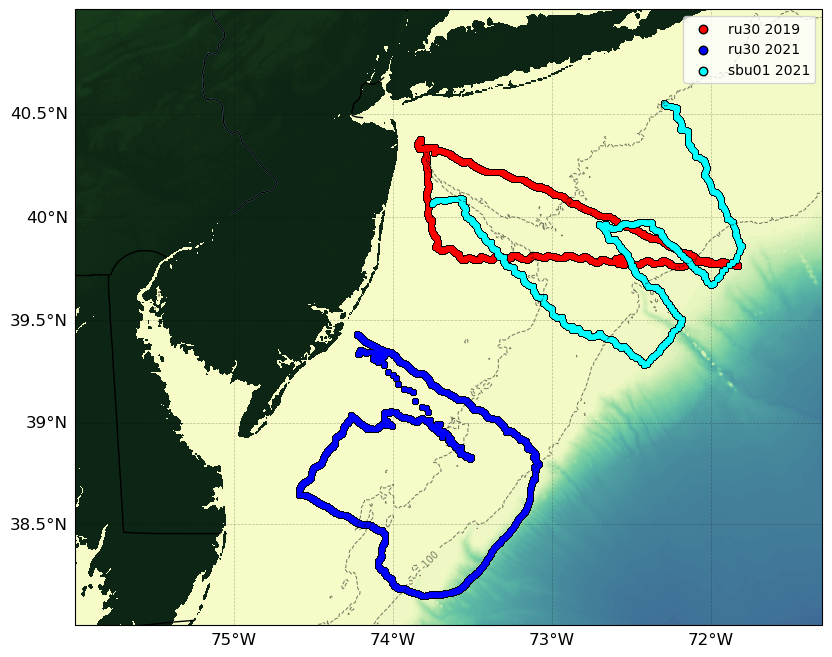

In [9]:
datasets = [ds_ru30_2019, ds_ru30_2021, ds_sbu01_2021]
deployment_colors = ['r', 'b', 'cyan']
deployment_labels = ['ru30 2019', 'ru30 2021', 'sbu01 2021']

sname = os.path.join(save_dir, 'glider_tracks.png')
plot_tracks(datasets, deployment_colors, deployment_labels, bathy_ds, extent, sname)

Print where you saved the plot and close it.

In [10]:
plt.close()
print(f'File saved to: {sname}')

File saved to: /Users/garzio/Documents/rucool/gliderplots/glider_tracks.png


Since we switched the file dimension to be "time", we can easily select a subset of the data if we just want to plot one section of each glider deployment. Since we're interested in cross-shelf transects, let's try to select just one cross-shelf transect for each deployment that traverses directly offshore. We will also eventually want to bin the data for each transect according to distance from shore, so we need to pick a point on land for each deployment to calculate distance from shore. Let's add those points on shore as the optional "points" input to the function.

In [11]:
ds_ru30_2019_sub = ds_ru30_2019.sel(time=slice(dt.datetime(2019, 7, 17, 16, 0), dt.datetime(2019, 7, 28, 0, 0)))
ds_ru30_2021_sub = ds_ru30_2021.sel(time=slice(dt.datetime(2021, 7, 16, 18, 0), dt.datetime(2021, 7, 24, 0, 0)))
ds_sbu01_2021_sub = ds_sbu01_2021.sel(time=slice(dt.datetime(2021, 8, 8, 18, 0), dt.datetime(2021, 8, 18, 12, 0)))

datasets = [ds_ru30_2019_sub, ds_ru30_2021_sub, ds_sbu01_2021_sub]

ds_ru30_2019_point = [-74, 40.45]
ds_ru30_2021_point = [-74.31, 39.48]
ds_sbu01_2021_point = [-73.98, 40.33]

onshore_points = [ds_ru30_2019_point, ds_ru30_2021_point, ds_sbu01_2021_point]

sname_sub = os.path.join(save_dir, 'glider_tracks_transects.png')

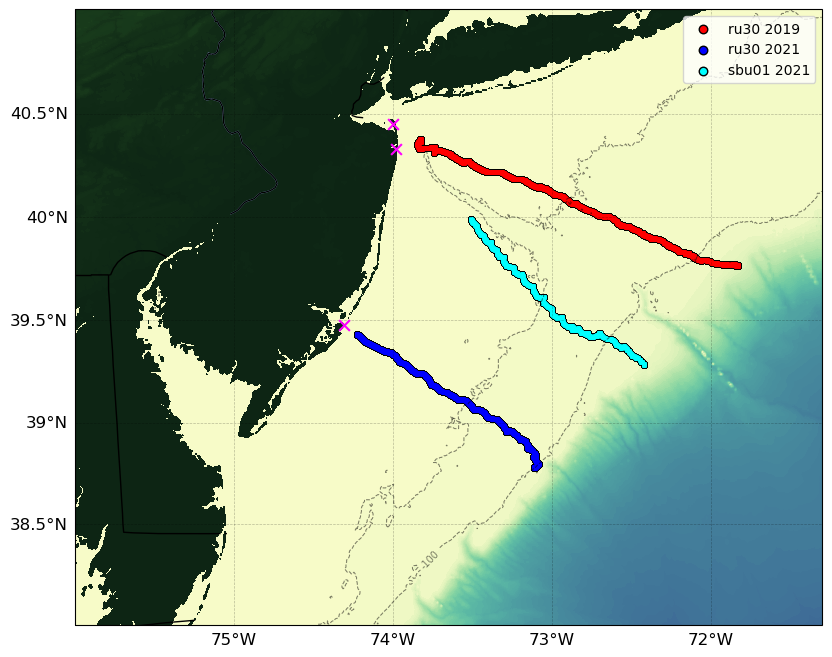

In [12]:
# run function with new inputs for subset glider transects
plot_tracks(datasets, deployment_colors, deployment_labels, bathy_ds, extent, sname_sub, points=onshore_points)

In [13]:
plt.close()
print(f'File saved to: {sname_sub}')

File saved to: /Users/garzio/Documents/rucool/gliderplots/glider_tracks_transects.png
